<a href="https://colab.research.google.com/github/Nov05/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/module3-dimensionality-reduction/High_Dimensional_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# modified by nov05 on 2019-06-19
# DS-Unit-1-Sprint-4-Linear-Algebra-master/
# module3-dimensionality-reduction/

**Lecture Notebook**  
https://colab.research.google.com/drive/19eXBnbYmtFFrNjqtLpnfdXoOMRSaS-1f  

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker 
import seaborn as sns

# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

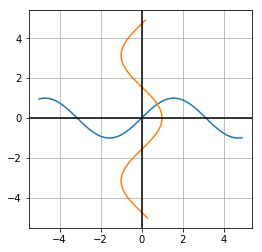

In [4]:
x1 = np.arange(-5, 5, 0.1)
y1 = np.sin(x1)

y2 = np.arange(-5, 5, 0.1)
x2 = np.cos(y2)

plt.figure(figsize=(4, 4))
ax = plt.subplot(111)
ax.grid(True)
plt.plot(x1, y1)
plt.plot(x2, y2)
ax.axhline(0, color='black')
ax.axvline(0, color='black');


## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

https://en.wikipedia.org/wiki/Vertical_line_test  
A function can only have one output, y, for each unique input, x. For the graphs that don't pass the vertical line test, a unique input might have mutiple outputs.

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

In [0]:
# R1: for input 1, there are two outputs 2 and 3. so it is not a function.
# R2: it is a function.
# R3: for input 9, there are two outputs 4 and 6. so it doesn't qualify as a function.
# R4: for input 6, there are two outputs 2 and 4. so it can't not be a function.
# R5: for input 2, there are two outputs 6 and 4. so it is not a function.

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

In [0]:
# 1. for m, 3D to 3D
# 2. for n, 4D to 2D

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

In [0]:
# 1. converting low resolution images to high resolution images
# 2. adding columns (creating features) to a dataset

# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

In [8]:
mp = [[1, 3],
      [2, -1]
     ]
mq = [[4, 1, 2],
      [2, -1, 3],
      [5, -2, 1]
     ]
input1 = [1, 1]
input2 = [2, 3]
input3 = [1, 1, 1]
input4 = [2, 3, 4]
print(np.matmul(mp, input1))
print(np.matmul(mp, input2))
print(np.matmul(mq, input3))
print(np.matmul(mq, input4))

[4 1]
[11  1]
[7 4 4]
[19 13  8]


## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

In [0]:
# verified

# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors  

In linear algebra, an eigenvector or characteristic vector of a linear transformation is a non-zero vector that changes by only a scalar factor when that linear transformation is applied to it. More formally, if T is a linear transformation from a vector space V over a field F into itself and v is a vector in V that is not the zero vector, then v is an eigenvector of T if T(v) is a scalar multiple of v. This condition can be written as the equation

T(v) = lamda * v

where λ is a scalar in the field F, known as the eigenvalue, characteristic value, or characteristic root associated with the eigenvector v.  

In [0]:
# @#$%^&* <- my own words

# alright. an eigenvector is a vector that won't change in direction but will 
# only change in length, when a linear transformation is applied to it. and the 
# length of the vector is its eigenvalue.

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

In [0]:
# 1. hard to imagine it with a human brain
# 2. more difficult to make sense of some information
# 3. more calculation

## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

In [0]:
# rule of thumb = a broadly accurate guide or principle, 
#                 based on experience or practice rather than theory

# like "number of observations should be at least 5 times of number
# of parameters"?

# Principal Component Analysis

## 7.1 Load the UCI Machine Learning Repository's [Iris Dataset](https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv) and use PCA to isolate the dataset's first and second principal components and plot them on a graph. 

In [13]:
url = "https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv"
iris = pd.read_csv(url)
print(iris.shape)
iris.head(4)

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa


In [14]:
iris.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [15]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [16]:
means = iris.describe().loc['mean']
stds = iris.describe().loc['std']
means

sepal_length    5.843333
sepal_width     3.054000
petal_length    3.758667
petal_width     1.198667
Name: mean, dtype: float64

In [57]:
# numpy array features

v1 = np.array([1, 2, 3, 4])
v2 = np.array([1, 2, 3, 4])
v3 = np.array([[1, 2, 3, 4],
               [2, 4, 6, 8]
             ])
print(v1/v2)
print(v3/2)

[1. 1. 1. 1.]
[[0.5 1.  1.5 2. ]
 [1.  2.  3.  4. ]]


In [76]:
# check values
pd.DataFrame([(np.array(row)-means) 
              for row in iris.iloc[:,:-1].values]).head(2)

,sepal_length,sepal_width,petal_length,petal_width
mean,-0.743333,0.446,-2.358667,-0.998667
mean,-0.943333,-0.054,-2.358667,-0.998667


In [44]:
# 4) Calculate the Variance-Covariance matrix of Z.
Z = pd.DataFrame([(np.array(row)-means) / stds
                  for row in iris.iloc[:,:-1].values])
Z.head(2)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593


In [21]:
print(Z.T.shape)
print(Z.shape)

(4, 150)
(150, 4)


In [77]:
# something with unknown meanings, ignore it
Y = pd.DataFrame([(np.array(row)-means)/(stds**2)
                  for row in iris.iloc[:,:-1].values])
ZY = np.matmul(Y.T.values, Y.values)
ZY

array([[ 217.29824962,  -45.3871493 ,   88.90234161,  192.85633652],
       [ -45.3871493 ,  792.53621585,  -81.89987551, -160.54615646],
       [  88.90234161,  -81.89987551,   47.8610385 ,  106.53318235],
       [ 192.85633652, -160.54615646,  106.53318235,  255.83162274]])

## Variance-Covariance  

<img src="https://cdn.educba.com/academy/wp-content/uploads/2019/05/Covariance-Formula.jpg" width="300">

In [82]:
# 4) Calculate the Variance-Covariance matrix of Z.
Z = pd.DataFrame([(np.array(row)-means) / stds
                  for row in iris.iloc[:,:-1].values])
COV = np.matmul(Z.T.values, Z.values)
print(COV)

[[149.         -16.29601824 129.89136944 121.87509137]
 [-16.29601824 149.         -62.65689836 -53.12506935]
 [129.89136944 -62.65689836 149.         143.45080746]
 [121.87509137 -53.12506935 143.45080746 149.        ]]


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cov.html  
Returns the covariance matrix of the DataFrame’s time series. The covariance is normalized by N-1.  

In [81]:
# see how far it is from a covariance matrix
print(iris.cov(), '\n')

U = pd.DataFrame([(np.array(row)-means)
                  for row in iris.iloc[:,:-1].values])
print(np.matmul(U.T.values, U.values)/(iris.shape[0]-1))

              sepal_length  sepal_width  petal_length  petal_width
sepal_length      0.685694    -0.039268      1.273682     0.516904
sepal_width      -0.039268     0.188004     -0.321713    -0.117981
petal_length      1.273682    -0.321713      3.113179     1.296387
petal_width       0.516904    -0.117981      1.296387     0.582414 

[[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]


In [27]:
iris.sepal_length.var()

0.6856935123042505

## Correlation Coefficient  

<img src="http://www.stat.yale.edu/Courses/1997-98/101/cor.gif" width="300">

In [78]:
W = pd.DataFrame([(np.array(row)-means) /stds
                  for row in iris.iloc[:,:-1].values])
np.matmul(W.T.values, W.values) / (iris.shape[0]-1)

array([[ 1.        , -0.10936925,  0.87175416,  0.81795363],
       [-0.10936925,  1.        , -0.4205161 , -0.35654409],
       [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ],
       [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ]])

In [26]:
iris.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


**What are the Eigenvectors and Eigenvalues of the Variance-Covariance Matrix?**  

In [28]:
# 5) Calculate the Eigenvectors and Eigenvalues of the Variance-Covariance Matrix.

# What are the Eigenvectors and Eigenvalues of the Variance-Covariance Matrix? 
# The eigenvectors are those that run along the dimensions that maximize the 
# variance along that dimension. Remember our rotated elipse example? When 
# we moved our elipse off of the x and y axis we then didn't know what line 
# we should project the points onto so that they we could collapse the dimension 
# of least variance. Well now we do!

eigenvalues, eigenvectors = np.linalg.eig(VC)
print(eigenvalues, '\n\n', eigenvectors)

[433.71189448 137.26191868  21.95563847   3.07054838] 

 [[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]


In [42]:
print(iris.head(), '\n')
print(eigenvectors[])

SyntaxError: ignored

# Stretch Goal

## 1) Do NOT work on the stretch goal until you feel like you have a firm grasp of eigenvectors, eigenvalues, and PCA. Prioritize self-study over the stretch goal if you are not comfortable with those topics yet.

## 2) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

<img src="https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg" width="400">

You don't necessarily have to use this resource, but this will get you started:   
https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/  

## Some other stuff

In [29]:
# Create a list of 50 random floats and add them to a dataframe
N = 50
x = np.random.rand(N)*100

# Crete Dataframe
data = {"x": x}
df = pd.DataFrame(data)
df.head(3)

,x
0,4.000540
1,62.875611
2,82.029254


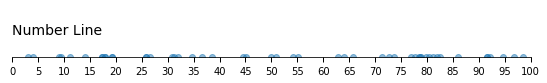

In [30]:
# Plot the floats on a number line

# Setup a plot such that only the bottom spine is shown
def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)
    
plt.figure(figsize=(8, 6))
n = 8

# Create some y values to satisfy matplotlib
df['y'] = pd.Series(list(np.zeros(50)))

# Multiple Locator tick mark settings
ax = plt.subplot(n, 1, 2)
setup(ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.text(0.0, 0.5, "Number Line", fontsize=14,
        transform=ax.transAxes)

# Push the top of the top axes outside the figure because we only show the
# bottom spine.
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=1.05)
plt.scatter(df.x, df.y, alpha=0.5)

plt.show()

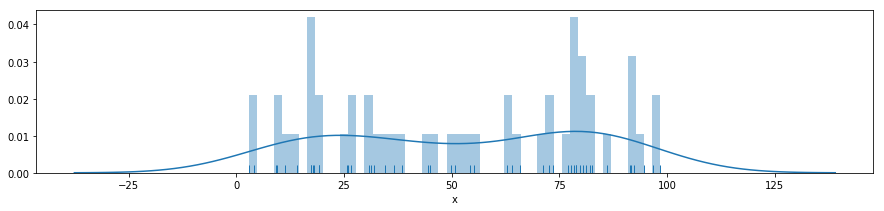

In [31]:
plt.figure(figsize=(15,3))
sns.distplot(df.iloc[:,0], 
             bins=len(df.iloc[:,0]), 
             rug=True);

https://seaborn.pydata.org/generated/seaborn.rugplot.html  

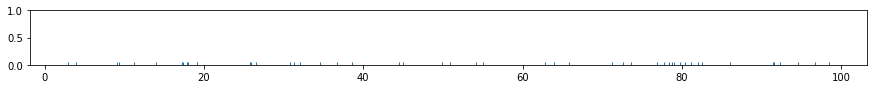

In [32]:
plt.figure(figsize=(15,1))
sns.rugplot(df.iloc[:,0]);

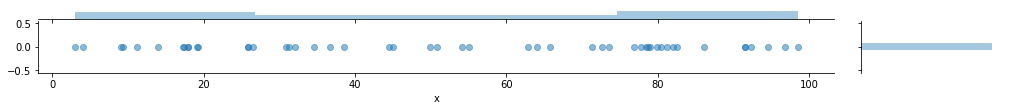

In [33]:
grid = sns.jointplot(df.iloc[:,0], [0]*len(df.iloc[:,0]),
                     alpha=0.5
                    )
grid.fig.set_figwidth(15)
grid.fig.set_figheight(1)